In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model


%matplotlib inline

In [2]:
df = pd.read_csv("../input/saratov-train-data/train_dataset_train.csv")

In [3]:
df.head(10)

,id,name,groups
0,2442477,БЗМЖ Молоко ультропаст.Вкуснотеево900гр.3.2%ПЭТ/б,3
1,1564599,"15.6"" Ноутбук Acer Nitro 5 (AN515-54-58LL)(FHD...",10
2,841848,ЖЕВ.РЕЗИНКА ОРБИТ НЕЖНАЯ МЯТА XX 46153708,10
3,960348,Агрикола Грунт универсальный 50 л (Техноэкспор...,10
4,398622,"1. Игристое вино ""Каспийская коллекция"" ЗГУ ""Д...",10
5,2743476,"Напиток Алое Вера б/г 0,5л. ВТ",4
6,3832875,Воздушный рис Дансония в карамели 30г /32,10
7,4906316,"Салат ""Сельдь под шубой"" (С)",10
8,2420905,"Молоко пастерил. Резной Палисад 3,4-4% 750г БЗМЖ",3
9,405595,"ВИНО ПИРОСМАНИ КРАСНОЕ ПОЛУСЛАДКОЕ 11,5% 0,75л",10


## Рассмотрим датасет по ближе

9 Хлебные изделия

1 Напитки газированные

0 Вода

3 Молоко 2.5-3.2 %

4 Молочные продукты

1 Макароны

6 Фрукты

7 Продукция общепитов

10 Товары без категории

In [4]:
df.groups.value_counts()

10    502764
9      42002
4      27591
0      21566
3      21045
1      17136
7      12051
6      10007
2       3902
Name: groups, dtype: int64

In [5]:
df["milk_percent"] = df.name.apply(lambda text: 1 if re.match(r'.+(3\.2)|(2\.5).+', text) else 0)

In [6]:
df[df["milk_percent"] == 1].groups.value_counts()

3     817
10    681
2      48
4      13
7       8
0       5
1       3
9       2
6       2
Name: groups, dtype: int64

In [7]:
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 609.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 17.0 MB/s eta 0:00:00


In [8]:
import nltk

import pymorphy2

word_tokenaizer = nltk.WordPunctTokenizer()

morph = pymorphy2.MorphAnalyzer()

nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('russian')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
df.shape

(658064, 4)

In [10]:
%%time
sample_size = 30000

df_sample = df#.sample(sample_size)
df_sample_splited = df_sample.name.str.split(r"\.|,| ")
df_sample_splited

CPU times: user 2.74 s, sys: 387 ms, total: 3.13 s
Wall time: 3.13 s


0         [БЗМЖ, Молоко, ультропаст, Вкуснотеево900гр, 3...
1         [15, 6", Ноутбук, Acer, Nitro, 5, (AN515-54-58...
2         [ЖЕВ, РЕЗИНКА, ОРБИТ, НЕЖНАЯ, МЯТА, XX, 46153708]
3         [Агрикола, Грунт, универсальный, 50, л, (Техно...
4         [1, , Игристое, вино, "Каспийская, коллекция",...
                                ...                        
658059              [8714100917541, ШАМПУНЬ, TRESEMME, BEA]
658060    [1/1, Ксилен, 0, 1%, капли, назальные, 10мл, ф...
658061             [СЫР, колбасный, ЯНТАРЬ, 1, кг, Воронеж]
658062                [Боди, длинный, рукав, для, девочек:]
658063         [1*2504, Вода, АКВА, МИНЕРАЛЕ, питьевая, 5л]
Name: name, Length: 658064, dtype: object

In [11]:
def text_processing(text):
    
    # нижний регистр
    #убираем, всё кроме букв и цифр.
    word_list = [word.lower() for word in text if re.match(r'^[а-яА-ЯёЁ]+$', word)]
    
    #убираем стоп слова
    word_list = [word for word in word_list if word not in stop_words]
    
    # леммезация
    out_text = ''
    for word in word_list:
        #out_text += morph.parse(word)[0].normal_form + " " 
        out_text += word + " " 
    
    return out_text

In [12]:
%%time
df_sample["lemmed_text"] = df_sample_splited.apply(lambda a: text_processing(a))

CPU times: user 13.4 s, sys: 99.9 ms, total: 13.5 s
Wall time: 13.5 s


In [13]:
df_sample

,id,name,groups,milk_percent,lemmed_text
0,2442477,БЗМЖ Молоко ультропаст.Вкуснотеево900гр.3.2%ПЭТ/б,3,1,бзмж молоко ультропаст
1,1564599,"15.6"" Ноутбук Acer Nitro 5 (AN515-54-58LL)(FHD...",10,0,ноутбук
2,841848,ЖЕВ.РЕЗИНКА ОРБИТ НЕЖНАЯ МЯТА XX 46153708,10,0,жев резинка орбит нежная мята
3,960348,Агрикола Грунт универсальный 50 л (Техноэкспор...,10,0,агрикола грунт универсальный л
4,398622,"1. Игристое вино ""Каспийская коллекция"" ЗГУ ""Д...",10,0,игристое вино згу белое россия
...,...,...,...,...,...
658059,5324046,8714100917541 ШАМПУНЬ TRESEMME BEA,10,0,шампунь
658060,2971888,1/1 Ксилен 0.1% капли назальные 10мл фл.-кап. ...,10,0,ксилен капли назальные фл полимер
658061,4713243,СЫР колбасный ЯНТАРЬ 1 кг Воронеж,10,0,сыр колбасный янтарь кг воронеж
658062,152642,Боди длинный рукав для девочек:,10,0,боди длинный рукав


In [14]:
# Макароны сильно зашумлены
# оставим только самые правильные 

#group1_data = df_sample[df_sample.groups == 1]

#vectorizer_group1 = CountVectorizer(max_features = 50, min_df=5)
#group1_vect = vectorizer_group1.fit_transform(df_sample[df_sample.groups == 1].lemmed_text)

#vectorizer_group1.vocabulary_.keys()

In [15]:
#group1_data

In [16]:
#vectorizer_group1.vocabulary_

In [17]:
#group1_data["grpup1_cnt"] = np.sum(group1_vect.toarray(),-1)
#group1_false_index = group1_data[group1_data.grpup1_cnt == 0].index
#group1_false_index.shape

In [18]:
#print(df_sample.shape)
#df_sample_ = df_sample.drop(group1_false_index, axis=0)
#print(df_sample_.shape)

In [19]:

vectorizer = CountVectorizer(max_features=8000, min_df=4)

X = vectorizer.fit_transform(df_sample.lemmed_text)
y = df_sample.groups
X

<658064x8000 sparse matrix of type '<class 'numpy.int64'>'
	with 2019083 stored elements in Compressed Sparse Row format>

In [20]:
#vectorizer.vocabulary_

In [21]:
from scipy.sparse import coo_matrix, hstack
#coo_matrix(df.head(10000).milk_percent.values).transpose()
#XX = hstack([X, coo_matrix(df_sample.milk_percent.values).transpose()])

XX = hstack([X, coo_matrix(df_sample.id.values).transpose()])

## Выделим выборки

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

In [23]:
print(X_train.shape, X_test.shape)

(526451, 8000) (131613, 8000)


## Обучение модели

In [24]:
%%time
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train, y_train) #, eval_set=(X_test, y_test), verbose=2)


CPU times: user 5h 8min 5s, sys: 5.94 s, total: 5h 8min 11s
Wall time: 5h 8min 17s


SVC()

In [25]:
%%time
pred = clf.predict(X_train)

score = recall_score(y_train, pred, average='macro')
print("Recall score:", score)
print(classification_report(y_train, pred))

Recall score: 0.939776867644412
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     17215
           1       0.96      0.78      0.86     13719
           2       0.98      0.91      0.95      3108
           3       0.99      0.97      0.98     16838
           4       1.00      0.98      0.99     22103
           6       0.99      0.94      0.96      8069
           7       0.98      0.93      0.95      9665
           9       0.95      0.97      0.96     33546
          10       0.99      1.00      0.99    402188

    accuracy                           0.99    526451
   macro avg       0.98      0.94      0.96    526451
weighted avg       0.99      0.99      0.99    526451

CPU times: user 49min 10s, sys: 601 ms, total: 49min 11s
Wall time: 49min 12s


In [26]:
%%time
pred = clf.predict(X_test)

score = recall_score(y_test, pred, average='macro')
print("Recall score:", score)
print(classification_report(y_test, pred))

Recall score: 0.9215241016070563
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      4351
           1       0.94      0.73      0.82      3417
           2       0.98      0.88      0.93       794
           3       0.99      0.97      0.98      4207
           4       0.99      0.97      0.98      5488
           6       0.97      0.90      0.94      1938
           7       0.96      0.89      0.92      2386
           9       0.94      0.97      0.96      8456
          10       0.98      1.00      0.99    100576

    accuracy                           0.98    131613
   macro avg       0.97      0.92      0.94    131613
weighted avg       0.98      0.98      0.98    131613

CPU times: user 12min 18s, sys: 126 ms, total: 12min 18s
Wall time: 12min 19s


<Figure size 720x720 with 0 Axes>

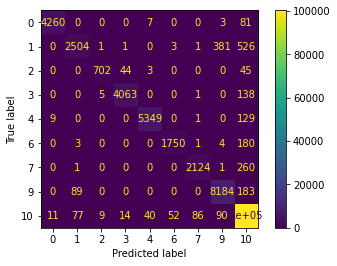

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.figure(figsize=(10,10))
#sns.heatmap(confusion_matrix(y_test, pred), annot=True, cmap='Blues')
#confusion_matrix(y_test, pred)
cm = confusion_matrix(y_test, pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                          display_labels=clf.classes_)
disp.plot()

plt.show()

In [28]:
#clf = RandomForestClassifier(random_state=0)



#model = linear_model.Lasso(alpha=0.1)

#model = RandomForestClassifier(random_state=0, n_jobs=-1)


#parameters = { 
#    'n_estimators': [50, 100],
   # 'max_features': ['auto', 'sqrt', 'log2'],
   # 'max_depth' : [75, 100, 150],
#    'criterion' :['gini', 'entropy']
#}


#parameters = {'alpha': [0.01, 0.1, 1, 10, 100]}

#parameters = {'n_estimators': [50, 100, 200]}

#clf = GridSearchCV(model, parameters, cv=2, scoring='f1_macro', verbose=3)

#clf = linear_model.RidgeClassifierCV(alphas=[0.01, 0.1, 1, 10, 100])

#clf.fit(X_train, y_train.values)

#print(clf.best_params_, clf.best_score_)
#print(clf.cv_values_)

In [29]:
#from catboost import CatBoostClassifier
#clf.fit(X_train, y_train)
#clf = RandomForestClassifier(n_estimators=70, random_state=0, criterion='entropy', n_jobs=-1, verbose=3)
#clf.fit(X_train, y_train)#, verbose=150)
#clf = CatBoostClassifier(depth=4, learning_rate=0.1, random_seed=0, early_stopping_rounds=30, n_estimators=10000)
#clf.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=50)

In [30]:

#pred = clf.predict(X_test)

#score = recall_score(y_test, pred, average='macro')
#print("Recall score:", score)
#print(classification_report(y_test, pred))

# v1 Recall score: 0.8646271211302988
# v2 Recall score: 0.9055411826597728
# Recall score: 0.9074533505833097



# Recall score: 0.9326956958405973

# Test test test!

In [31]:
#testdf = pd.read_csv("../input/saratovtestdata/test_dataset_test.csv")
#testdf

In [32]:
testdf = pd.read_csv("../input/saratovtestdata-new/test_dataset_saratov.csv")
testdf.shape

(282227, 2)

In [33]:
testdf

,id,name
0,10529,"КАРАМЕЛЬ ""ЛАКОМКА-СУПЕРМОЛОЧНАЯ"" ВЕС (РОТ ФРОНТ)"
1,10530,"2: 3637233 РАЭ Масло ТРАДИЦ.слив.82,5% 1"
2,10531,960012-LG NS Бинт эластичный Classic лаймовый...
3,10532,Вода мин. 1.5л пл/у (Сахалинская)
4,10533,Ролики натяжителя ремня AMD.GTA0740 AMD
...,...,...
282222,292751,Пельмени Московские Пижанка 800г
282223,292752,Активиа 135гр Пробиотик малина
282224,292753,Базилик овощной
282225,292754,JACOBS Millicano Кофе Crema Espresso раств с мол


In [34]:
testdf.isna().sum()
testdf.dropna(axis=0, inplace=True)
testdf.shape

(282227, 2)

In [35]:
testdf["milk_percent"] = testdf.name.apply(lambda text: 1 if re.match(r'.+(3\.2)|(2\.5).+', text) else 0)

In [36]:
df_test_splited = testdf.name.str.split(r"\.|,| ")
df_test_splited

0         [КАРАМЕЛЬ, "ЛАКОМКА-СУПЕРМОЛОЧНАЯ", ВЕС, (РОТ,...
1         [2:, 3637233, РАЭ, Масло, ТРАДИЦ, слив, 82, 5%...
2         [960012-LG, NS, , Бинт, эластичный, Classic, л...
3                 [Вода, мин, , 1, 5л, пл/у, (Сахалинская)]
4            [Ролики, натяжителя, ремня, AMD, GTA0740, AMD]
                                ...                        
282222                [Пельмени, Московские, Пижанка, 800г]
282223                  [Активиа, 135гр, Пробиотик, малина]
282224                                   [Базилик, овощной]
282225    [JACOBS, Millicano, Кофе, Crema, Espresso, рас...
282226              [ШЕБА, плежур, Форель, , Креветки, 85г]
Name: name, Length: 282227, dtype: object

In [37]:
%%time
testdf["lemmed_text"] = df_test_splited.apply(lambda a: text_processing(a))

CPU times: user 5.6 s, sys: 33 ms, total: 5.63 s
Wall time: 5.63 s


In [38]:
XX_test = vectorizer.transform(testdf.lemmed_text)

In [39]:
#XX_test = hstack([XX_test, coo_matrix(df.head(10000).milk_percent.values).transpose()])

In [40]:
pred = clf.predict(XX_test)
pred

array([10, 10, 10, ..., 10, 10, 10])

In [41]:
testdf["groups"] = pred

In [42]:
print(testdf.shape)

(282227, 5)


In [43]:
subm = testdf[["id", "groups"]]
subm.to_csv("solution_saratov_160922_1100.csv", index=False)

In [44]:
print(subm.shape)

(282227, 2)
